# Import needed libraries
To make things work ensure that you have this libraries installed.

In [3]:
import os
import numpy as np
import splitfolders
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from string import digits
from imutils import paths
from random import choices
from typing import Tuple, List
import matplotlib.pyplot as plt
from tensorflow.keras import Model
import tensorflow.keras.backend as K
from tensorflow.data import AUTOTUNE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from classification_models.keras import Classifiers
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import GRU, Dense, Bidirectional,  Reshape, Flatten, BatchNormalization, GlobalMaxPooling2D, Dense, Dropout, Input, Concatenate

2024-06-06 07:15:15.598252: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 07:15:15.598381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 07:15:15.728232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data
The **Dataset** class is designed as a helper tool for loading and preparing image datasets for training machine learning models.

In [4]:
class Dataset:

    MAX_IMAGES_PER_GENRE = 5_000
    
    def __init__(self, path: str, output: str | None = None, ratio: Tuple[float, float, float] = (.70, .15, .15), split: bool = True, split_folders: bool = False, image_size: Tuple[int, int] = (224,224), batch_size: int = 8 , cache: bool = True):
        assert sum(ratio) == 1.0

        self.path = path
        self.labels = [name for name in tqdm(os.listdir(self.path)) if os.path.isdir(os.path.join(self.path, name))]
        
        self.cache = cache
        self.ratio = ratio
        
        self.output_path = output if output else f"./data-{''.join(choices(digits, k=5))}"
        
        self.train = os.path.sep.join([self.output_path, 'train'])
        self.val = os.path.sep.join([self.output_path, 'val'])
        self.test = os.path.sep.join([self.output_path, 'test'])
        
        self.image_size = image_size
        self.batch_size = batch_size
        
        assert split == True or split_folders == True or output is not None
        
        if split:
            self.__split()
        elif split_folders:
            self.__split_folder()
            
        self.__generate()
    
    def __split(self):
        tmp_ratio = (1.0 - self.ratio[0])
        val_test_ratio = self.ratio[1] / tmp_ratio
        
        def get_genres(path):
            genres = {}
            for image_path in tqdm(list(paths.list_images(path))):
                genre = os.path.basename(os.path.dirname(image_path))

                if genre not in genres:
                    genres[genre] = []
                
                if len(genres[genre]) >= Dataset.MAX_IMAGES_PER_GENRE:
                    continue
                
                genres[genre].append(image_path)
            
            return genres

        
        def split_genre(genre):
            train, tmp = train_test_split(genre, test_size=tmp_ratio, random_state=42)
            test, val = train_test_split(tmp, test_size=val_test_ratio, random_state=42)
            
            return train, val, test
        
        self.train, self.val, self.test = [], [], []
        genres = get_genres(self.path)
        for genre in genres.values():
            train, val, test = split_genre(genre)
            self.train.extend(train)
            self.val.extend(val)
            self.test.extend(test)
    
        np.random.shuffle(self.train)
        np.random.shuffle(self.val)
        np.random.shuffle(self.test)
    
    def __split_folder(self):
        splitfolders.ratio(self.path, output=self.output_path, seed=42, ratio=self.ratio, group_prefix=None)
    
    def __generate(self):
        def load_images(image_path):
            image = tf.io.read_file(image_path)
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)
            image = tf.image.resize(image, self.image_size)
            
            label = tf.strings.split(image_path, os.path.sep)[-2]
            label = tf.cast(tf.equal(self.labels, label), tf.int32)
    
            return (image, label)
        
        def get_paths(x):
            if isinstance(x, str):
                return paths.list_images(x)
            else:
                return x
        
        train_paths = get_paths(self.train)
        self.train_len = len(train_paths) // self.batch_size
        self.train = tf.data.Dataset.from_tensor_slices(train_paths)
        self.train = (self.train
            .shuffle(len(train_paths), reshuffle_each_iteration=True)
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(AUTOTUNE)
        )
        
        if self.cache:
            self.train = self.train.cache()
        
        val_paths = get_paths(self.val)
        self.val_len = len(val_paths) // self.batch_size
        self.val = tf.data.Dataset.from_tensor_slices(val_paths)
        self.val = (self.val
            .shuffle(len(val_paths))
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(AUTOTUNE)
        )
        
        if self.cache:
            self.val = self.val.cache()
        
        test_paths = get_paths(self.test)
        self.test_len = len(test_paths) // self.batch_size
        self.test = tf.data.Dataset.from_tensor_slices(test_paths)
        self.test = (self.test
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .batch(self.batch_size)
            .prefetch(AUTOTUNE)
        )
        
        if self.cache:
            self.test = self.test.cache()

# Helper functions
The following functions are helpful tools for visualising model training progress and evaluating model performance through confusion matrix analysis.

In [5]:
def plot_history(history, metric: str = '', ylim: List[float] | None = None):
    h = history.history
    plt.figure(figsize=(15,5))
    plt.plot(h[metric])
    plt.plot(h[f'val_{metric}'])
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend([metric, f'val_{metric}'], loc='upper left')
    if ylim:
        axes = plt.gca()
        axes.set_ylim(ylim)
    plt.show()

def plot_models(
    metric='',
    histories=[],
    names=[],
    styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-'],
    name = None, val = False, ylim = None,
    colors=['b','g','y','c','m','r','k','b','g','y','c','m','r','k','b','g','y','c','m','r','k','b','g','y','c','m','r','k']
):
    def add_val_after_each_element(lst):
        new_lst = []
        for item in lst:
            new_lst.append(item)
            new_lst.append(item + '- val')
        return new_lst
    
    plt.clf()
    plt.figure(figsize=(25,5))
    for i, h in enumerate(histories):
        plt.plot(h.history[metric],linestyle=styles[i] if isinstance(styles, list) else styles, color=colors[i] if isinstance(colors, list) else colors)
        if val:
            plt.plot(h.history[f'val_{metric}'], linestyle='dotted', color=colors[i] if isinstance(colors, list) else colors)
    plt.title(f'model {name if name else metric}')
    plt.ylabel(name if name else metric)
    plt.xlabel('epoch')
    plt.legend(names if not val else add_val_after_each_element(names), loc='upper left')
    if ylim:
        axes = plt.gca()
        axes.set_ylim(ylim)
    plt.show()

def show_confusion_matrix(y_true, y_pred, labels: List[str] = []):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(labels), len(labels)))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# BiGRU + ResNet-18
The **build_model** function is a utility designed to construct and compile a model. The **STFT** and **Mel Spectrogram** are used to learn this model.

In [6]:
ResNet18, _ = Classifiers.get('resnet18')
input_shape = (224, 224, 3)
genres = 10

In [7]:
def build_model(input_shape: Tuple[int, int, int] = (224, 224, 3), genres: int = 10):
    width, height, channels = input_shape    
    kernel_regularizer=tf.keras.regularizers.l2(0.001)
    
    # Create the model
    inputs = Input(shape=input_shape)

    ################
    ### ResNet18 ###
    ################
    resnet18 = ResNet18(input_shape=input_shape, weights='imagenet', include_top=False)
    resnet18.trainable = True

    resnet18 = resnet18(inputs)
    resnet18 = GlobalMaxPooling2D()(resnet18)

    resnet18 = Dense(256, activation='relu', kernel_regularizer=kernel_regularizer)(resnet18)
    resnet18 = Dense(128, activation='relu', kernel_regularizer=kernel_regularizer)(resnet18)


    resnet18 = Dropout(0.5)(resnet18)
    resnet18 = BatchNormalization()(resnet18)

    ################
    #### Bi-GRU ####
    ################
    bi_gru = Reshape((width, height * channels))(inputs)
    bi_gru = Bidirectional(GRU(256, return_sequences=True))(bi_gru)
    bi_gru = Flatten()(bi_gru)

    bi_gru = Dense(256, activation='relu', kernel_regularizer=kernel_regularizer)(bi_gru)
    bi_gru = Dense(128, activation='relu', kernel_regularizer=kernel_regularizer)(bi_gru)  

    ################
    #### CONCAT ####
    ################
    combined_output = Concatenate()([resnet18, bi_gru])
    final_output = Dropout(0.5)(combined_output)

    final_output = Dense(128, activation='relu', kernel_regularizer=kernel_regularizer)(final_output)
    final_output = Dense(64, activation='relu', kernel_regularizer=kernel_regularizer)(final_output) 

    final_output = Dense(genres, activation='softmax')(final_output)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model = Model(inputs=inputs, outputs=final_output)
    
    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# GTZAN 

## Short-Time Fourier Transform

In [7]:
batch_size = 32
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/stft', batch_size=batch_size, cache=False)

100%|██████████| 4995/4995 [00:00<00:00, 248241.01it/s]


In [28]:
model = build_model()
history = model.fit(
    dataset.train,
    batch_size=batch_size,
    epochs=50,
    steps_per_epoch=dataset.train_len,
    validation_data=dataset.val,
    validation_steps=dataset.val_len,
    verbose=1
)

Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 33s 173ms/step - accuracy: 0.1252 - loss: 3.8642 - val_accuracy: 0.1929 - val_loss: 3.3459
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step - accuracy: 0.2857 - loss: 3.1537 - val_accuracy: 0.4182 - val_loss: 2.8902
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - accuracy: 0.4083 - loss: 2.7783 - val_accuracy: 0.4003 - val_loss: 2.7158
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.4924 - loss: 2.4906 - val_accuracy: 0.4979 - val_loss: 2.4955
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.5887 - loss: 2.2494 - val_accuracy: 0.5186 - val_loss: 2.3935
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.6311 - loss: 2.0739 - val_accuracy: 0.5323 - val_loss: 2.2815
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.6737 - loss: 1.9332 - val_accuracy: 0.4525 - val_loss: 2.4810
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.7516 - loss: 1

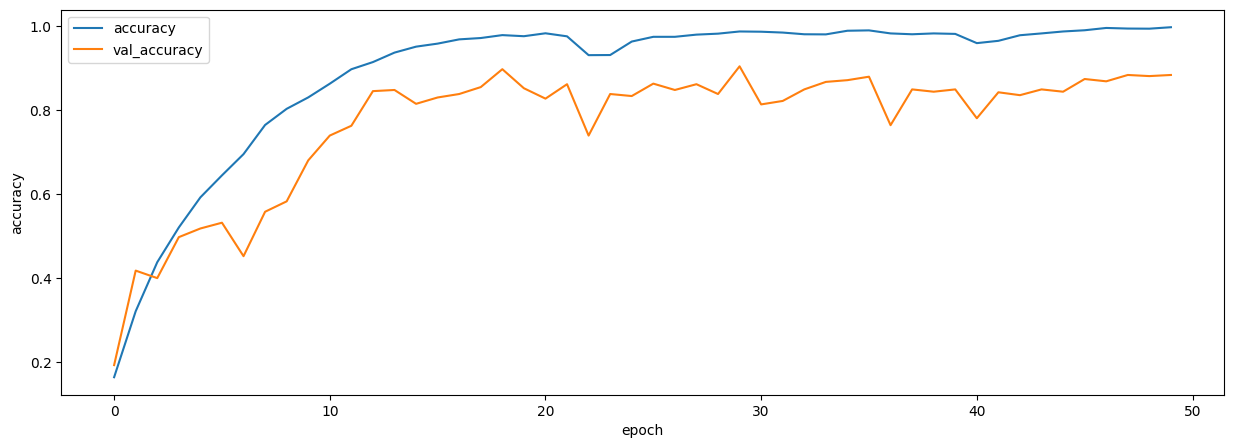

In [29]:
plot_history(history, metric='accuracy')

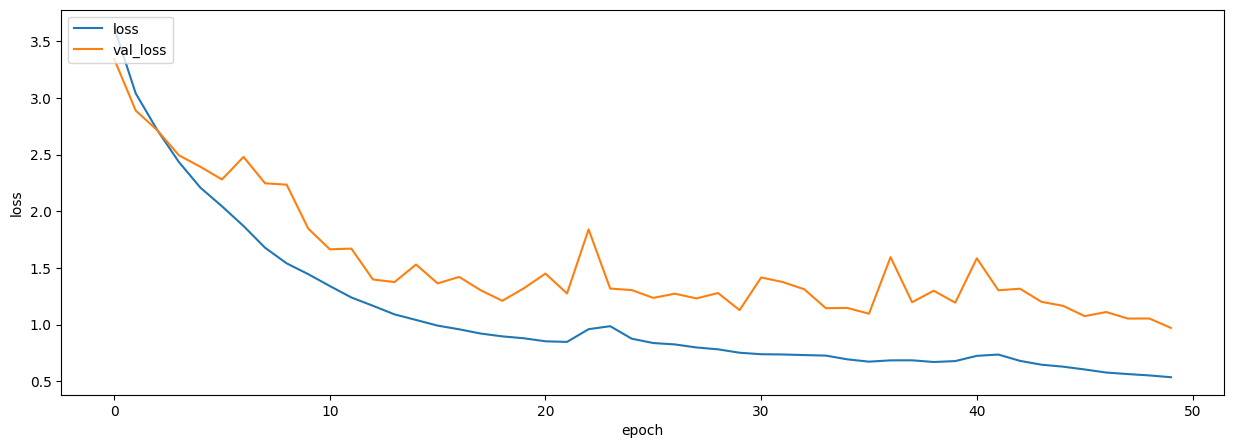

In [30]:
plot_history(history, metric='loss')

In [31]:
evaluation = model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8895 - loss: 0.8702
Accuracy: 0.8918558359146118
Loss: 0.8975887894630432


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step


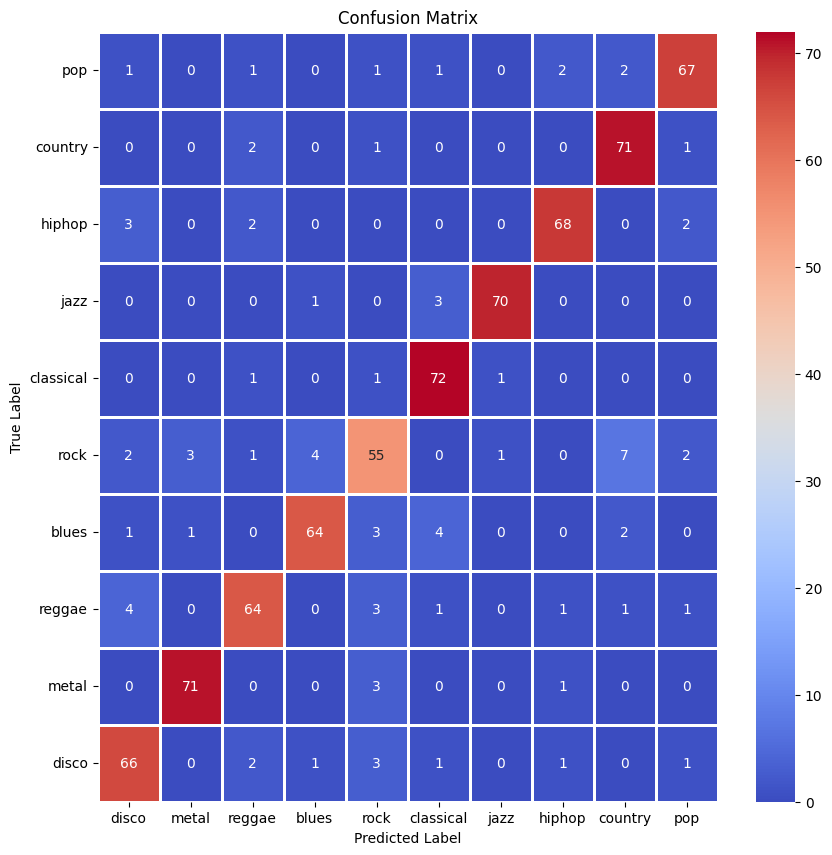

              precision    recall  f1-score   support

           0       0.86      0.88      0.87        75
           1       0.95      0.95      0.95        75
           2       0.88      0.85      0.86        75
           3       0.91      0.85      0.88        75
           4       0.79      0.73      0.76        75
           5       0.88      0.96      0.92        75
           6       0.97      0.95      0.96        74
           7       0.93      0.91      0.92        75
           8       0.86      0.95      0.90        75
           9       0.91      0.89      0.90        75

    accuracy                           0.89       749
   macro avg       0.89      0.89      0.89       749
weighted avg       0.89      0.89      0.89       749



In [32]:
y_pred = model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))

## Mel Spectogram


In [7]:
batch_size = 32
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/mel_spectrogram', batch_size=batch_size, cache=False)

100%|██████████| 4995/4995 [00:00<00:00, 258907.65it/s]


In [8]:
model = build_model()
history = model.fit(
    dataset.train,
    batch_size=batch_size,
    epochs=50,
    steps_per_epoch=dataset.train_len,
    validation_data=dataset.val,
    validation_steps=dataset.val_len,
    verbose=1
)

44920640/44920640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 38s 178ms/step - accuracy: 0.1328 - loss: 3.9606 - val_accuracy: 0.2242 - val_loss: 3.3540
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - accuracy: 0.2940 - loss: 3.2251 - val_accuracy: 0.2517 - val_loss: 3.0448
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.4019 - loss: 2.8223 - val_accuracy: 0.3012 - val_loss: 3.0039
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.5075 - loss: 2.5346 - val_accuracy: 0.3122 - val_loss: 2.8313
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.5601 - loss: 2.3126 - val_accuracy: 0.3260 - val_loss: 2.8455
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.6316 - loss: 2.0956 - val_accuracy: 0.3329 - val_loss: 2.8328
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.6846 - loss: 1.9115 - val_accuracy: 0.4553 - val_loss: 2.4955
Epoch 8/50
108/108 ━━━━━━━━━━━━━

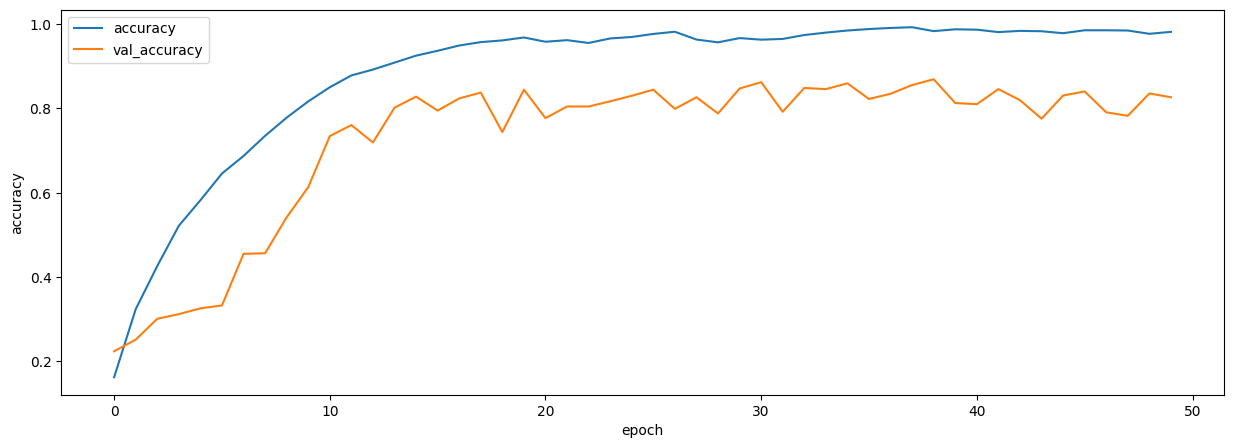

In [9]:
plot_history(history, metric='accuracy')

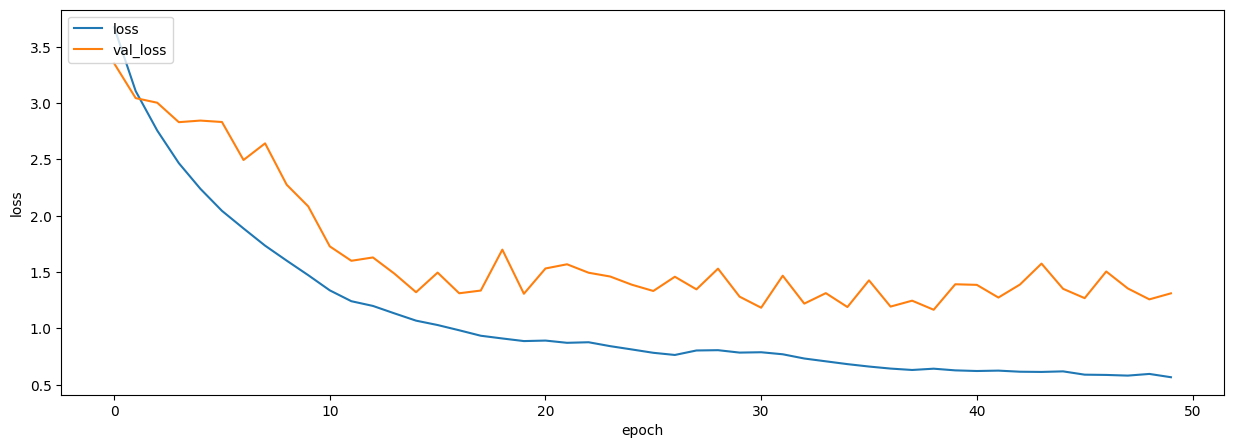

In [10]:
plot_history(history, metric='loss')

In [11]:
evaluation = model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.8345 - loss: 1.2432
Accuracy: 0.851802408695221
Loss: 1.141554832458496


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step


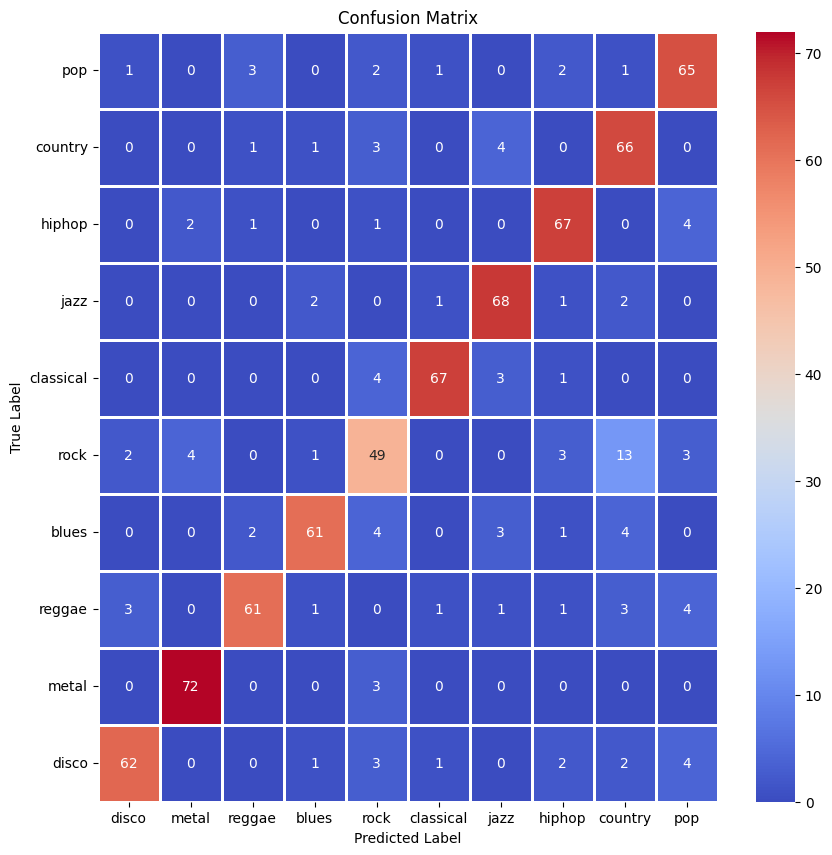

              precision    recall  f1-score   support

           0       0.91      0.83      0.87        75
           1       0.92      0.96      0.94        75
           2       0.90      0.81      0.85        75
           3       0.91      0.81      0.86        75
           4       0.71      0.65      0.68        75
           5       0.94      0.89      0.92        75
           6       0.86      0.92      0.89        74
           7       0.86      0.89      0.88        75
           8       0.73      0.88      0.80        75
           9       0.81      0.87      0.84        75

    accuracy                           0.85       749
   macro avg       0.86      0.85      0.85       749
weighted avg       0.86      0.85      0.85       749



In [12]:
y_pred = model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))

# FMA

## Short-Time Fourier Transform

In [8]:
batch_size = 32
dataset = Dataset(path='/kaggle/input/fma-images/stft/stft', batch_size=batch_size, cache=False)

100%|██████████| 64846/64846 [00:00<00:00, 279291.79it/s]


In [9]:
model = build_model(genres=15)
history = model.fit(
    dataset.train,
    batch_size=batch_size,
    epochs=50,
    steps_per_epoch=dataset.train_len,
    validation_data=dataset.val,
    validation_steps=dataset.val_len,
    verbose=1
)

44920640/44920640 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 207s 167ms/step - accuracy: 0.2776 - loss: 3.4796 - val_accuracy: 0.4244 - val_loss: 2.7017
Epoch 2/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 187s 165ms/step - accuracy: 0.4366 - loss: 2.6422 - val_accuracy: 0.5282 - val_loss: 2.2776
Epoch 3/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 184s 164ms/step - accuracy: 0.5236 - loss: 2.2996 - val_accuracy: 0.5646 - val_loss: 2.1100
Epoch 4/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 183s 163ms/step - accuracy: 0.5716 - loss: 2.0753 - val_accuracy: 0.6100 - val_loss: 1.8979
Epoch 5/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 183s 163ms/step - accuracy: 0.6190 - loss: 1.8584 - val_accuracy: 0.6361 - val_loss: 1.7734
Epoch 6/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 183s 162ms/step - accuracy: 0.6727 - loss: 1.6457 - val_accuracy: 0.6933 - val_loss: 1.5579
Epoch 7/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 181s 161ms/step - accuracy: 0.7178 - loss: 1.4499 - val_accuracy: 0.6955 - val_loss: 1.4910
Epoch 8/50


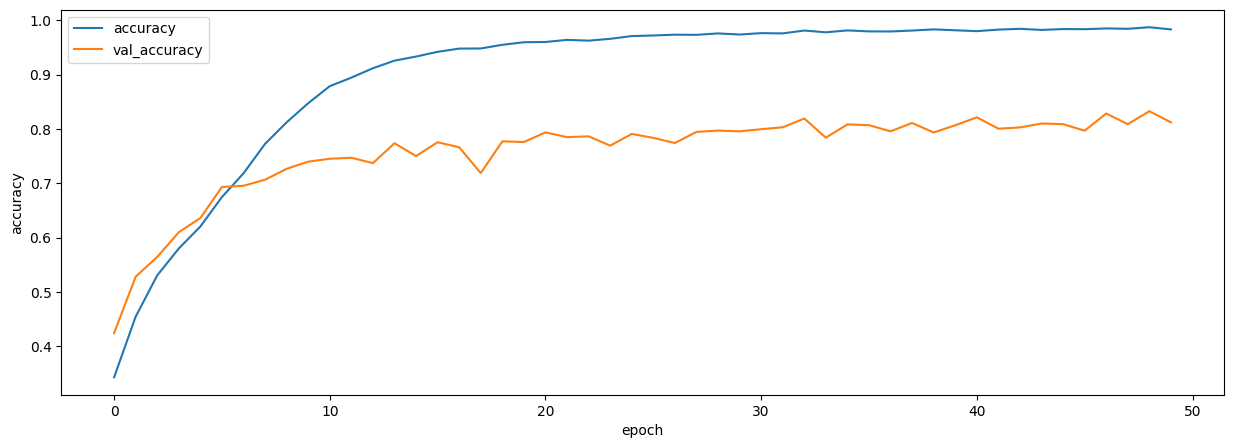

In [10]:
plot_history(history, metric='accuracy')

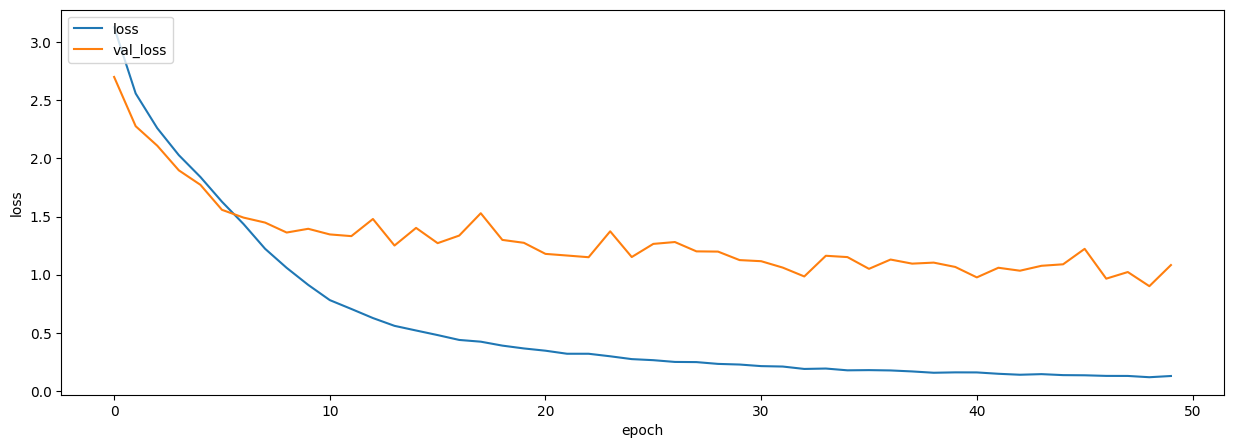

In [11]:
plot_history(history, metric='loss')

In [12]:
evaluation = model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

242/242 ━━━━━━━━━━━━━━━━━━━━ 24s 99ms/step - accuracy: 0.8181 - loss: 1.0514
Accuracy: 0.8162155151367188
Loss: 1.0453476905822754


242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step


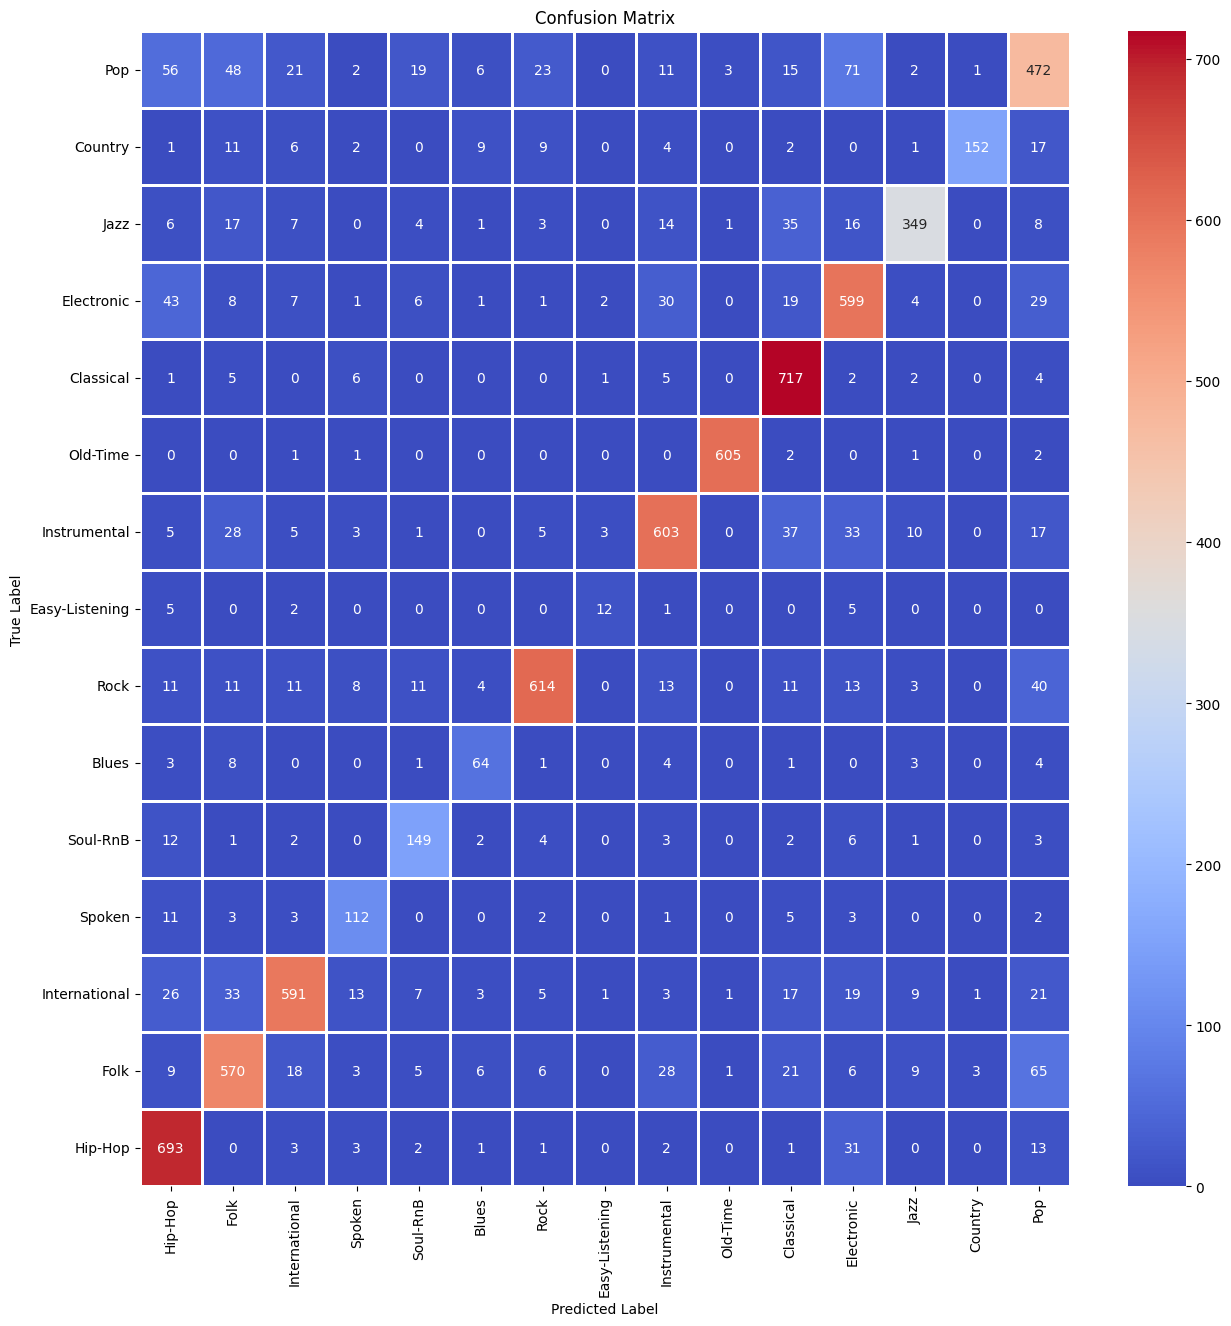

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       750
           1       0.77      0.76      0.76       750
           2       0.87      0.79      0.83       750
           3       0.73      0.79      0.76       142
           4       0.73      0.81      0.76       185
           5       0.66      0.72      0.69        89
           6       0.91      0.82      0.86       750
           7       0.63      0.48      0.55        25
           8       0.84      0.80      0.82       750
           9       0.99      0.99      0.99       612
          10       0.81      0.97      0.88       743
          11       0.75      0.80      0.77       750
          12       0.89      0.76      0.82       461
          13       0.97      0.71      0.82       214
          14       0.68      0.63      0.65       750

    accuracy                           0.82      7721
   macro avg       0.80      0.78      0.79      7721
weighted avg       0.82   

In [13]:
y_pred = model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))

## Mel Spectogram

In [8]:
batch_size = 32
dataset = Dataset(path='/kaggle/input/fma-images/mel/mel', batch_size=batch_size, cache=False)

100%|██████████| 64842/64842 [00:00<00:00, 248836.92it/s]


In [9]:
model = build_model(genres=15)
history = model.fit(
    dataset.train,
    batch_size=batch_size,
    epochs=50,
    steps_per_epoch=dataset.train_len,
    validation_data=dataset.val,
    validation_steps=dataset.val_len,
    verbose=1
)

44920640/44920640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 206s 166ms/step - accuracy: 0.2478 - loss: 3.5215 - val_accuracy: 0.4015 - val_loss: 2.7445
Epoch 2/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 184s 162ms/step - accuracy: 0.4570 - loss: 2.5945 - val_accuracy: 0.5387 - val_loss: 2.2556
Epoch 3/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 182s 162ms/step - accuracy: 0.5291 - loss: 2.2914 - val_accuracy: 0.5773 - val_loss: 2.0707
Epoch 4/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 182s 162ms/step - accuracy: 0.5832 - loss: 2.0498 - val_accuracy: 0.5755 - val_loss: 2.0135
Epoch 5/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 182s 161ms/step - accuracy: 0.6255 - loss: 1.8492 - val_accuracy: 0.6199 - val_loss: 1.8048
Epoch 6/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 181s 161ms/step - accuracy: 0.6756 - loss: 1.6405 - val_accuracy: 0.6215 - val_loss: 1.8054
Epoch 7/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 181s 161ms/step - accuracy: 0.7235 - loss: 1.4235 - val_accuracy: 0.6836 - val_loss: 1.5657
Epoch 8/50


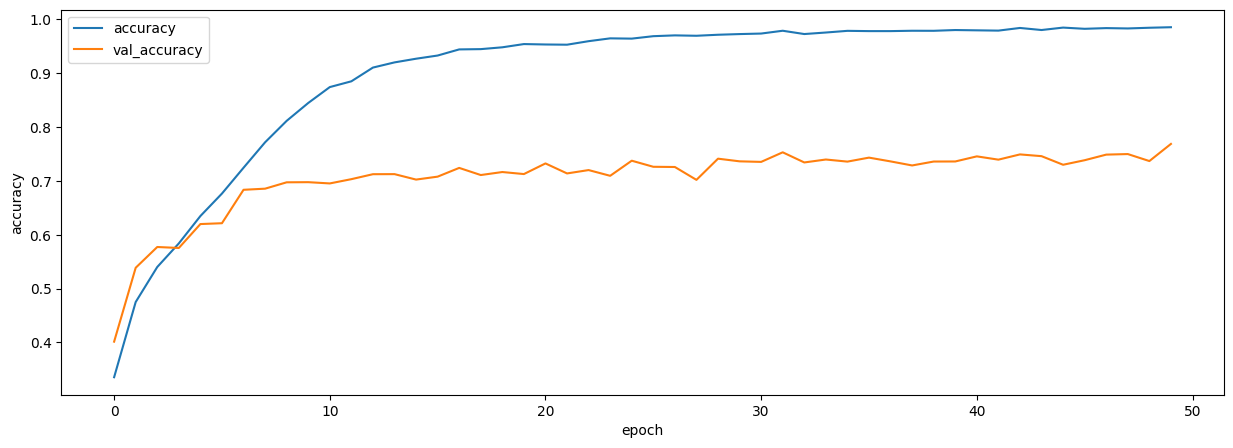

In [10]:
plot_history(history, metric='accuracy')

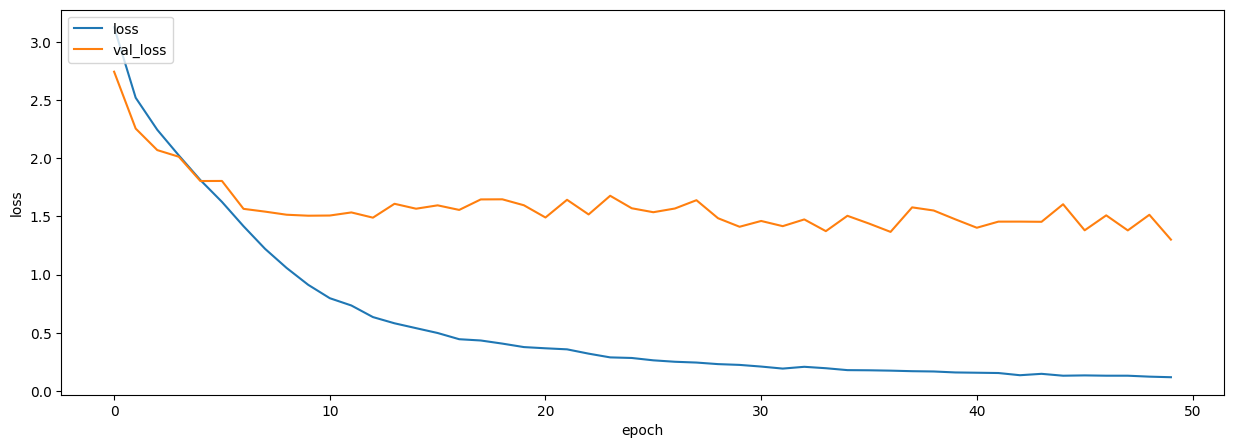

In [11]:
plot_history(history, metric='loss')

In [12]:
evaluation = model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.7785 - loss: 1.2452
Accuracy: 0.7666105628013611
Loss: 1.3238786458969116


242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step


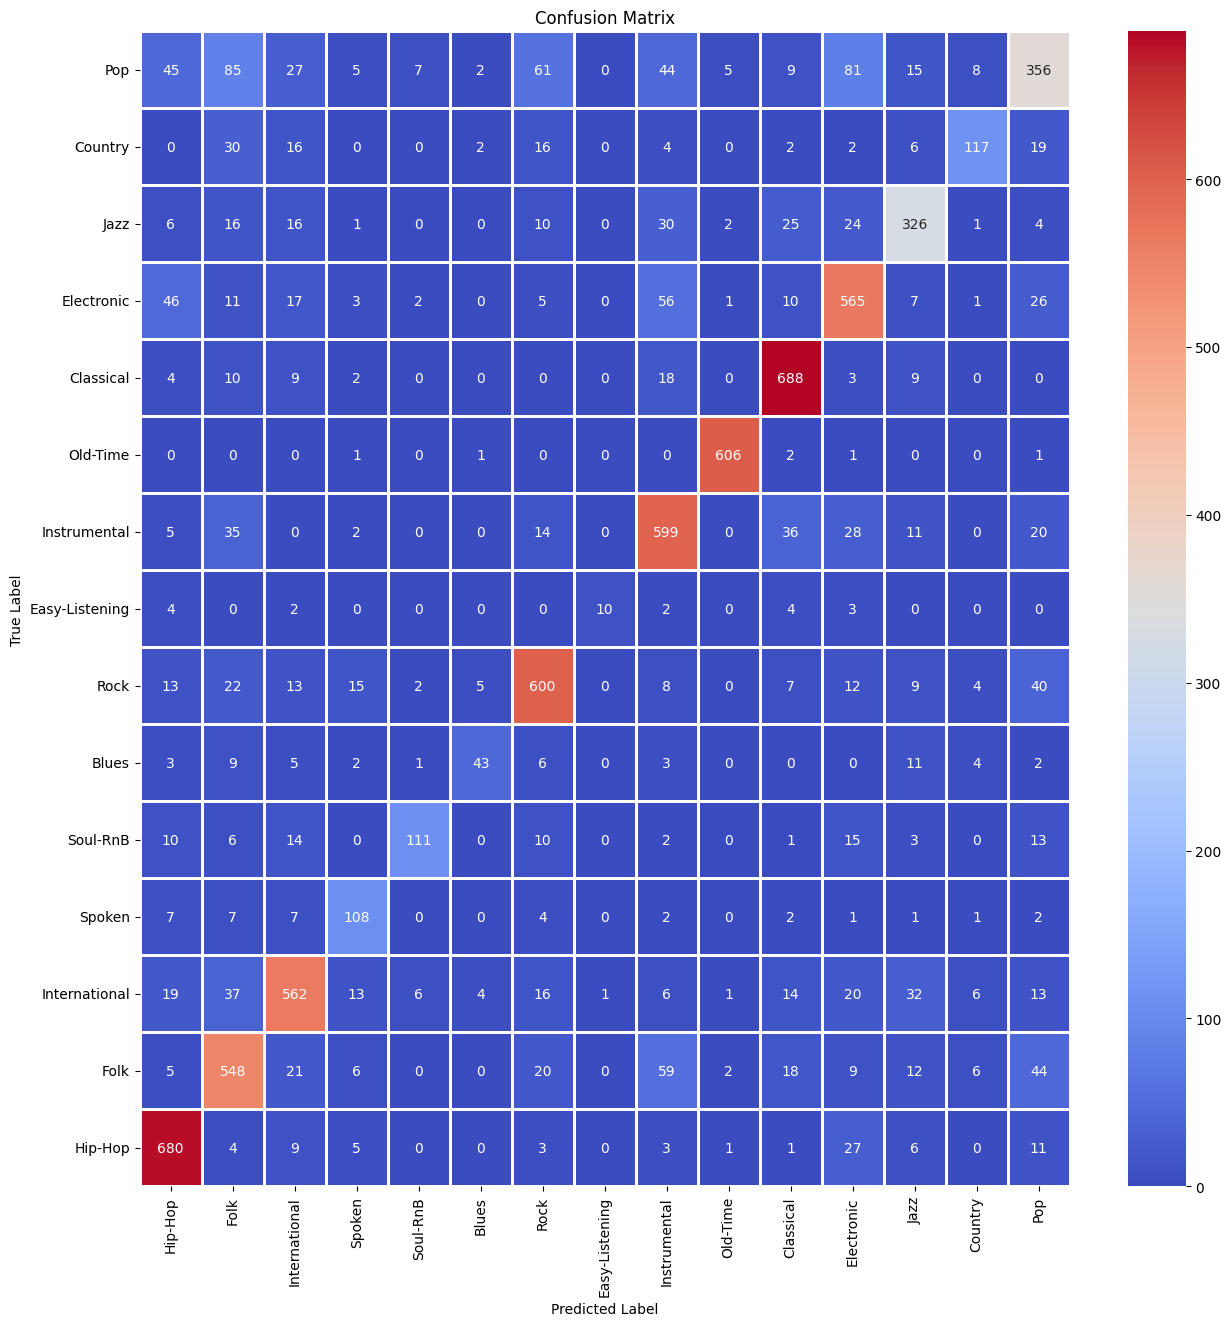

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       750
           1       0.67      0.73      0.70       750
           2       0.78      0.75      0.77       750
           3       0.66      0.76      0.71       142
           4       0.86      0.60      0.71       185
           5       0.75      0.48      0.59        89
           6       0.78      0.80      0.79       750
           7       0.91      0.40      0.56        25
           8       0.72      0.80      0.76       750
           9       0.98      0.99      0.99       612
          10       0.84      0.93      0.88       743
          11       0.71      0.75      0.73       750
          12       0.73      0.71      0.72       461
          13       0.79      0.55      0.65       214
          14       0.65      0.47      0.55       750

    accuracy                           0.77      7721
   macro avg       0.78      0.71      0.73      7721
weighted avg       0.77   

In [13]:
y_pred = model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))